<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Ames Housing Data and Kaggle Challenge


## Problem Statement

We are consultants hired by A real estate developer, researching on what factors impact the sale price most


how to allocate resources to improve participation rates and/or scores for SAT and/or ACT in the United States.
In this project, we intend to evaluate if there is a ACT score bias for households with higher or lower median income. Specifically, we will explore the association of statewide ACT mean score and median family income, and try to establish a linear regression model between them


### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hypothesis Test](#Hypothesis-Test)
- [Linear regression model](#Linear-regression-model)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Data Visualization](#Visualize-the-Data)

## Background

# Import libraries

In [178]:
# Imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LassoCV, RidgeCV,Ridge,Lasso
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,PolynomialFeatures


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer



import copy

get_ipython().run_line_magic('matplotlib', 'inline')


pd.options.display.max_columns = None
pd.options.display.max_rows = None


is_delete_outliers = False



# define some functions

In [179]:
def plot_features_numeric(df,x_columns, y_column):
    fig, axs = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for i in range(len(x_columns)):
        sns.histplot(data=df, x=x_columns[i], kde=True, color="skyblue", ax=axs[i])
    sns.pairplot(df, x_vars=x_columns, y_vars=y_column)

In [180]:
def plot_features_catagorical(df,x_columns, y_column):
    fig, axs = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for i in range(len(x_columns)):
        sns.histplot(data=df, x=x_columns[i], kde=False, color="skyblue", ax=axs[i])
    
    fig2, axs2 = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for j in range(len(x_columns)):
         sns.boxplot(x=x_columns[j], y=y_column, data=df, ax=axs2[j])
    

In [181]:
def proccess_outliers_IQR(df, feature, cut_off_IQR, direction="both", flag="delete"):
    print("feature name:", feature)
    # calculate interquartile range
    q25, q75 = df[feature].quantile(0.25), df[feature].quantile(0.75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * cut_off_IQR
    lower, upper = q25 - cut_off, q75 + cut_off
    
    if direction == 'both':
        # identify outliers
        outliers_lower = df[(df[feature] <= lower)].values
        outliers_upper =  df[(df[feature]>= upper)].values
        print('Identified outliers: %d' 
          % (len(outliers_lower)+ len(outliers_upper))
         )
        if flag == "delete":
            out = df[(df[feature]<= lower) | (df[feature]>=upper)].index
            df.drop(out, inplace=True)
            print("deleted the outliers")
        elif flag == 'replace':
            df[feature].replace(outliers_lower, lower, inplace=True)
            df[feature].replace(outliers_upper, upper, inplace=True)
            print("replaced the outliers")
        else:
            print("did not process the outliers")
    elif direction == 'lower':
        # identify outliers
        outliers_lower = df[(df[feature] <= lower)].values
        print('Identified outliers: %d' % (len(outliers_lower)))

        if flag == "delete":
            out = df[(df[feature]<= lower)].index
            df.drop(out, inplace=True)
            print("deleted the outliers")
        elif flag == 'replace':
            df[feature].replace(outliers_lower, lower, inplace=True)
            print("replaced the outliers")
        else:
            print("did not process the outliers")
    elif direction == 'upper':
        outliers_upper =  df[(df[feature]>= upper)].values
        print('Identified outliers: %d' % (len(outliers_upper)))
        
        if flag == "delete":
            out = df[(df[feature]>=upper)].index
            df.drop(out, inplace=True)
            print("deleted the outliers")
        elif flag == 'replace':
            df[feature].replace(outliers_upper, upper, inplace=True)
            print("replaced the outliers")
        else:
            print("did not process the outliers")
    else:
        print("did not process the outliers")
        

## Data Import and Cleaning

In [182]:
# read the files
df = pd.read_csv("../datasets/train.csv")
df.head().T

,0,1,2,3,4
Id,109,544,153,318,255
PID,533352170,531379050,535304180,916386060,906425045
MS SubClass,60,60,20,60,50
MS Zoning,RL,RL,RL,RL,RL
Lot Frontage,NaN,43.0,68.0,73.0,82.0
Lot Area,13517,11492,7922,9802,14235
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
Lot Shape,IR1,IR1,Reg,Reg,IR1
Land Contour,Lvl,Lvl,Lvl,Lvl,Lvl


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

### after comparing the data directory and dataframe Dtypes, and found the following columns need to convert to string type
- id
- pid
- ms_subclass

In [184]:
#rename column
#df.columns=df.columns.str.lower()
#df.columns=df.columns.str.replace(" ","_")
#change column type, according to data directory

df["Id"]=df["Id"].astype("str")
df["PID"]=df["PID"].astype("str")
df["MS SubClass"]=df["MS SubClass"].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2051 non-null   object  
 1   PID              2051 non-null   object  
 2   MS SubClass      2051 non-null   category
 3   MS Zoning        2051 non-null   object  
 4   Lot Frontage     1721 non-null   float64 
 5   Lot Area         2051 non-null   int64   
 6   Street           2051 non-null   object  
 7   Alley            140 non-null    object  
 8   Lot Shape        2051 non-null   object  
 9   Land Contour     2051 non-null   object  
 10  Utilities        2051 non-null   object  
 11  Lot Config       2051 non-null   object  
 12  Land Slope       2051 non-null   object  
 13  Neighborhood     2051 non-null   object  
 14  Condition 1      2051 non-null   object  
 15  Condition 2      2051 non-null   object  
 16  Bldg Type        2051 non-null   object  


In [185]:
features_categorical = [
       'MS SubClass', 'Sale Type', 'Misc Feature','Garage Type','Central Air','Heating','Foundation', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Neighborhood', 'Lot Config', 'Land Contour',
       'Alley', 'Street', 'MS Zoning'
]


features_ordinal = [
       'Fence', 'Pool QC',
       'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish',
       'Fireplace Qu', 'Functional', 'Kitchen Qual',
       'Electrical',  'Heating QC', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Exter Cond', 'Exter Qual',
       'Land Slope', 'Utilities',
       'Lot Shape','Overall Qual', 'Overall Cond'
]


features_numeric = [
        'Lot Frontage', 'Lot Area', 
       'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo Sold', 'Yr Sold'
]

#print(features_numeric)
df[features_categorical]=df[features_categorical].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2051 non-null   object  
 1   PID              2051 non-null   object  
 2   MS SubClass      2051 non-null   category
 3   MS Zoning        2051 non-null   category
 4   Lot Frontage     1721 non-null   float64 
 5   Lot Area         2051 non-null   int64   
 6   Street           2051 non-null   category
 7   Alley            140 non-null    category
 8   Lot Shape        2051 non-null   object  
 9   Land Contour     2051 non-null   category
 10  Utilities        2051 non-null   object  
 11  Lot Config       2051 non-null   category
 12  Land Slope       2051 non-null   object  
 13  Neighborhood     2051 non-null   category
 14  Condition 1      2051 non-null   category
 15  Condition 2      2051 non-null   category
 16  Bldg Type        2051 non-null   category


#rearrange the columns such that all feature of 'object' type will be moved before all numeric 

df2=pd.DataFrame()
columns_copy = df.columns.tolist()[2:]
for column in columns_copy:
    if df[column].dtype == object:
        column_to_reorder = df.pop(column)
        df.insert(3, column, column_to_reorder)
        df[column] = df[column].astype('category')
   # else:
    #    df2.insert(-1, df.columns[i], column_to_reorder)
df.info()

In [186]:
print("from above, we can see: column #2 to #44 are of catagorical features  ")
print("from above, we can see: column #44 and above are of numeric features  ")

from above, we can see: column #2 to #44 are of catagorical features  
from above, we can see: column #44 and above are of numeric features  




features_catagorical = df.select_dtypes(include='category').columns
print(features_catagorical)

features_numeric = df.select_dtypes(include='number').columns
print(features_numeric)

## checking null values

In [187]:
(df.isnull().sum()/len(df)).sort_values(ascending=False)

Pool QC            0.995612
Misc Feature       0.968308
Alley              0.931741
Fence              0.804973
Fireplace Qu       0.487567
Lot Frontage       0.160897
Garage Finish      0.055583
Garage Qual        0.055583
Garage Yr Blt      0.055583
Garage Cond        0.055583
Garage Type        0.055095
Bsmt Exposure      0.028279
BsmtFin Type 2     0.027304
BsmtFin Type 1     0.026816
Bsmt Cond          0.026816
Bsmt Qual          0.026816
Mas Vnr Area       0.010726
Mas Vnr Type       0.010726
Bsmt Half Bath     0.000975
Bsmt Full Bath     0.000975
Garage Area        0.000488
Total Bsmt SF      0.000488
Bsmt Unf SF        0.000488
BsmtFin SF 2       0.000488
BsmtFin SF 1       0.000488
Garage Cars        0.000488
Mo Sold            0.000000
Sale Type          0.000000
Full Bath          0.000000
Half Bath          0.000000
Bedroom AbvGr      0.000000
Kitchen AbvGr      0.000000
Kitchen Qual       0.000000
Yr Sold            0.000000
Misc Val           0.000000
Pool Area          0

we will not consider the following features with too many null value:

|feature|null value %|
------------------------------
Pool QC            0.995612

Misc Feature       0.968308

Alley              0.931741

Fence              0.804973

Fireplace Qu       0.487567

Lot Frontage       0.160897

In [188]:
features_numeric.remove('Lot Frontage')
df.drop(columns=['Lot Frontage'],inplace=True)
print(features_numeric)

['Lot Area', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold']


In [189]:
features_categorical.remove('Misc Feature')
features_categorical.remove('Alley')
features_ordinal.remove('Pool QC')
features_ordinal.remove('Fence')
features_ordinal.remove('Fireplace Qu')

df.drop(columns=['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu'],inplace=True)

print(features_categorical)
print(features_ordinal)

['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Neighborhood', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning']
['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope', 'Utilities', 'Lot Shape', 'Overall Qual', 'Overall Cond']


In [190]:
df.isnull().sum().sort_values(ascending=False)

Garage Yr Blt      114
Garage Finish      114
Garage Qual        114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Garage Area          1
Garage Cars          1
Total Bsmt SF        1
Full Bath            0
Gr Liv Area          0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Functional           0
Kitchen Qual         0
TotRms AbvGrd        0
2nd Flr SF           0
Fireplaces           0
Paved Drive          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
Sale Type            0
Low Qual Fin SF      0
Id                   0
1st Flr SF 

In [191]:
df.fillna(df.mean(),inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)
df.isnull().sum().sort_values(ascending=False)

C:\Users\olive\AppData\Local\Temp/ipykernel_4748/2047886619.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(),inplace=True)


Id                 0
Garage Type        0
Functional         0
TotRms AbvGrd      0
Kitchen Qual       0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Electrical         0
Central Air        0
Fireplaces         0
Garage Yr Blt      0
Heating            0
Garage Finish      0
Sale Type          0
Yr Sold            0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Paved Drive        0
Garage Cond        0
Garage Qual        0
Garage Area        0
Garage Cars        0
Heating QC         0
Total Bsmt SF      0
PID                0
Year Built         0
Overall Qual       0
House Style        0
Bldg Type          0
Condition 2        0
Condition 1        0
Neighborhood       0
Land Slope         0
Lot Config   

# cleaning and selecting numeric features:
- check if there is linear relation between the feature and 'saleprice'
- check if any outlier and clean if neccessary
- check the histogram of the feature

## check and handle outliers of features_numeric[0:5]

In [194]:
df.shape

(2051, 75)

['Lot Area', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1']


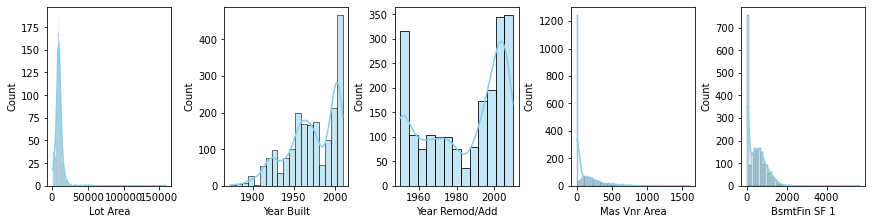

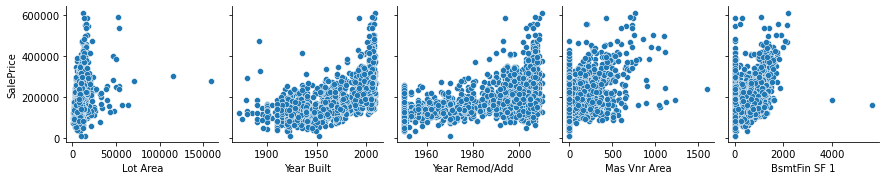

In [195]:
print(features_numeric[:5])
plot_features_numeric(df,features_numeric[:5],"SalePrice")

In [196]:
# features_numeric[0], features_numeric[3], and features_numeric[4] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [0,3,4]
outliers_values = [100_000, 1_500, 3_000]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of Lot Area:  2
deleted outliers of Lot Area
number of outliers of Mas Vnr Area:  1
deleted outliers of Mas Vnr Area
number of outliers of BsmtFin SF 1:  2
deleted outliers of BsmtFin SF 1


(2046, 75)


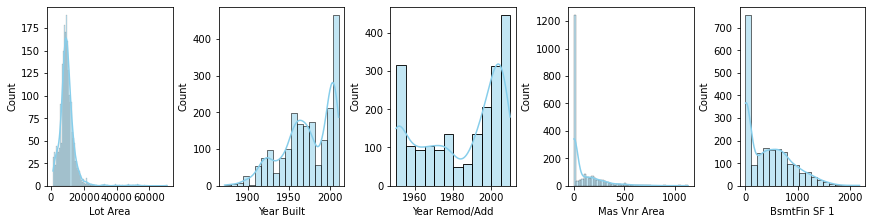

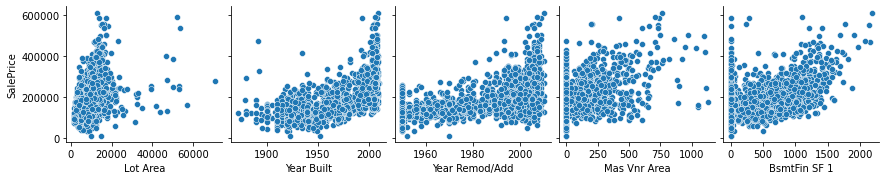

In [198]:
print(df.shape)
plot_features_numeric(df,features_numeric[:5],"SalePrice") 

## check and handle outliers of features_numeric[5:10]

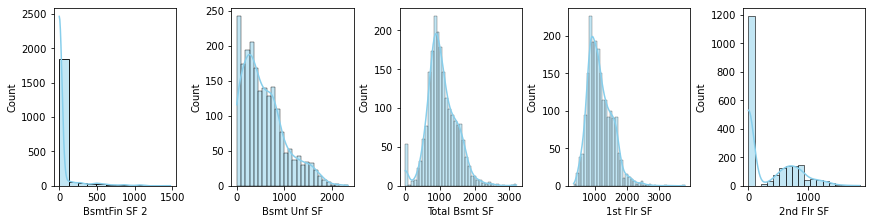

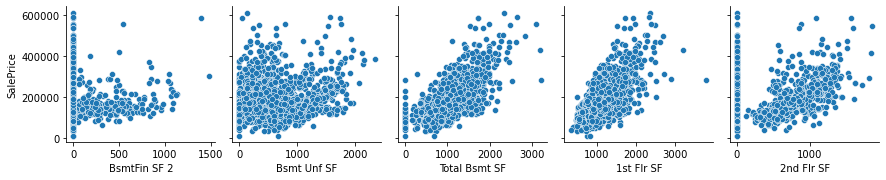

In [199]:
plot_features_numeric(df,features_numeric[5:10],"SalePrice")

In [200]:
# features_numeric[5], features_numeric[7], and features_numeric[8] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [5,7,8]
outliers_values = [1_300, 2_900, 3_000]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of BsmtFin SF 2:  2
deleted outliers of BsmtFin SF 2
number of outliers of Total Bsmt SF:  3
deleted outliers of Total Bsmt SF
number of outliers of 1st Flr SF:  1
deleted outliers of 1st Flr SF


(2040, 75)


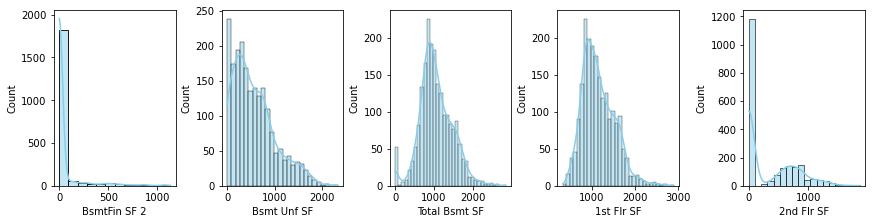

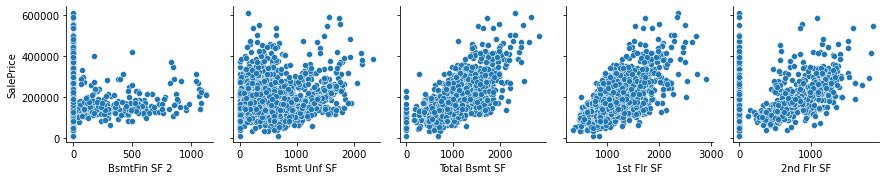

In [201]:
print(df.shape)
plot_features_numeric(df,features_numeric[5:10],"SalePrice") 

## check and handle outliers of features_numeric[10:15]

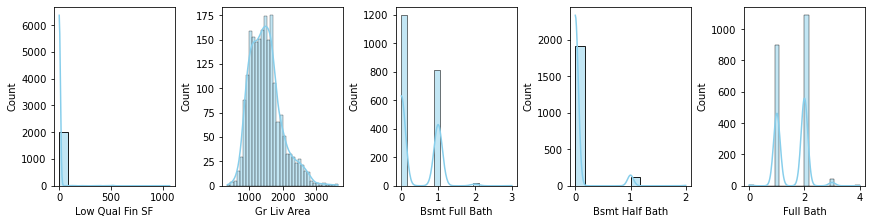

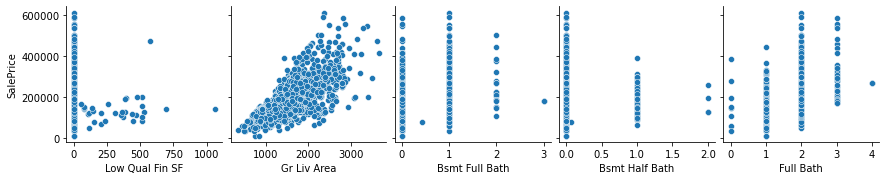

In [202]:
plot_features_numeric(df,features_numeric[10:15],"SalePrice")

In [209]:
# features_numeric[10], features_numeric[12]have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [10]
outliers_values = [570]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")

j = 12
outliers =  df[ (df[features_numeric[j]] > 0) & (df[features_numeric[j]] <1)] 
print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
df.drop(outliers.index, inplace=True)
print(f"deleted outliers of {features_numeric[j]}")


number of outliers of Low Qual Fin SF:  1
deleted outliers of Low Qual Fin SF
number of outliers of Bsmt Full Bath:  0
deleted outliers of Bsmt Full Bath


(2036, 75)


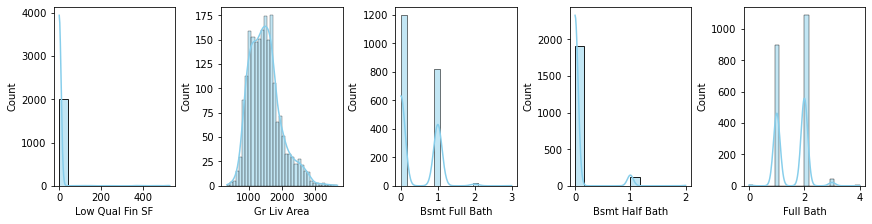

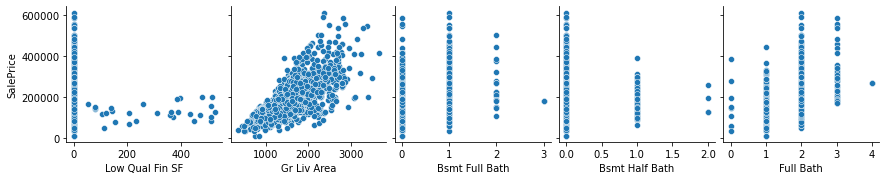

In [210]:
print(df.shape)
plot_features_numeric(df,features_numeric[10:15],"SalePrice") 

## check and handle outliers of features_numeric[15:20]

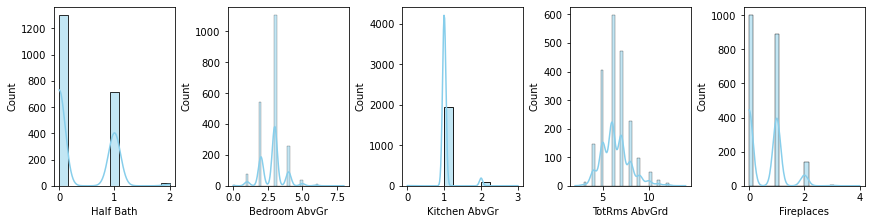

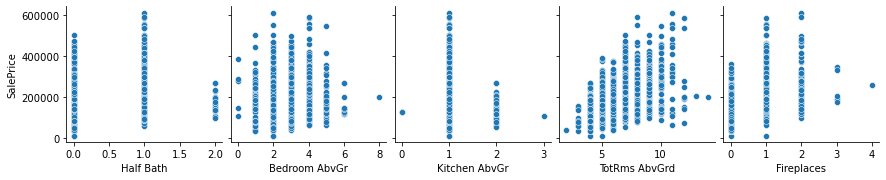

In [211]:
plot_features_numeric(df,features_numeric[15:20],"SalePrice")

In [213]:
print("No outliers found")

No outliers found


## check and handle outliers of features_numeric[20:25]

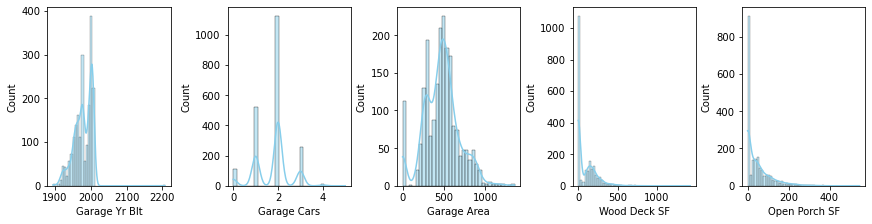

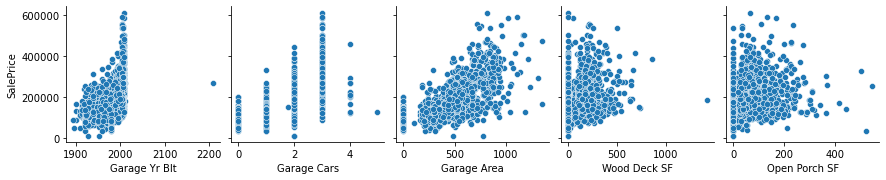

In [214]:
plot_features_numeric(df,features_numeric[20:25],"SalePrice")

In [217]:
# features_numeric[20], features_numeric[23], and features_numeric[24] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [20,23,24]
outliers_values = [2_100, 800, 420]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of Garage Yr Blt:  0
deleted outliers of Garage Yr Blt
number of outliers of Wood Deck SF:  1
deleted outliers of Wood Deck SF
number of outliers of Open Porch SF:  0
deleted outliers of Open Porch SF


(2029, 75)


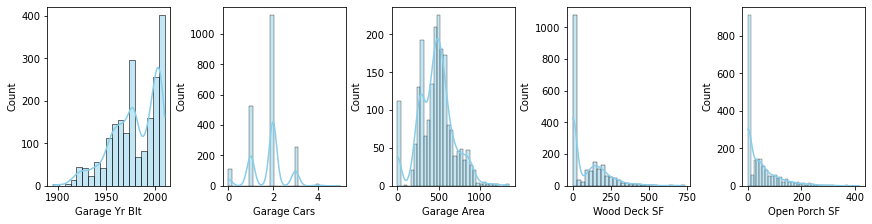

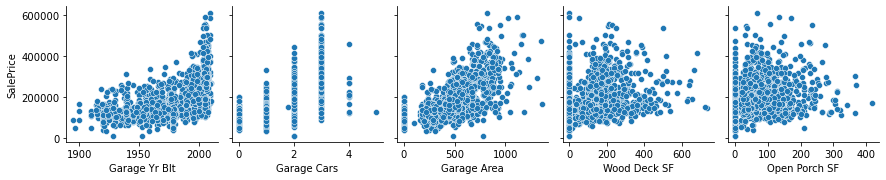

In [218]:
print(df.shape)
plot_features_numeric(df,features_numeric[20:25],"SalePrice") 

## check and handle outliers of features_numeric[25:30]

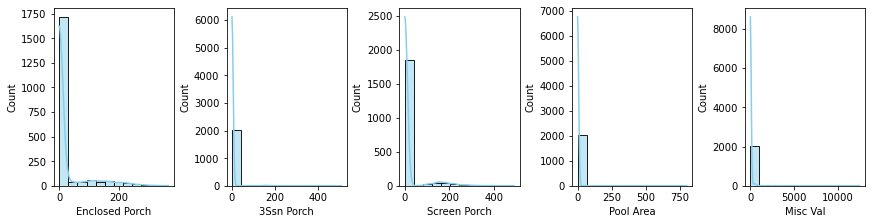

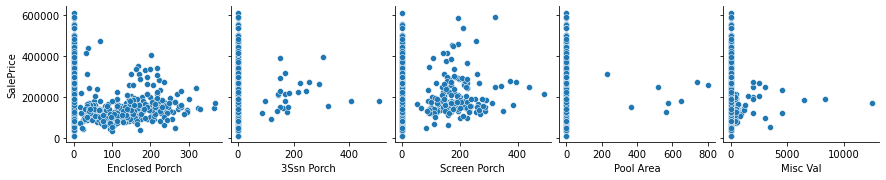

In [219]:
plot_features_numeric(df,features_numeric[25:30],"SalePrice")

In [220]:
# features_numeric[26], features_numeric[29] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [26,29]
outliers_values = [350, 10_000]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of 3Ssn Porch:  2
deleted outliers of 3Ssn Porch
number of outliers of Misc Val:  1
deleted outliers of Misc Val


(2026, 75)


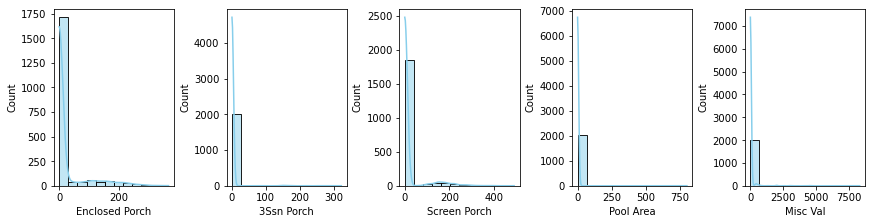

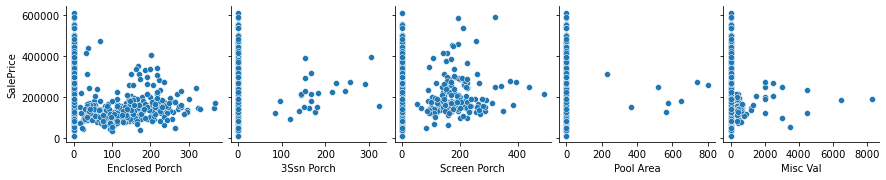

In [221]:
print(df.shape)
plot_features_numeric(df,features_numeric[25:30],"SalePrice") 

In [222]:
print(features_numeric[30:])

['Mo Sold', 'Yr Sold']


## check and handle outliers of features_numeric[30:35]

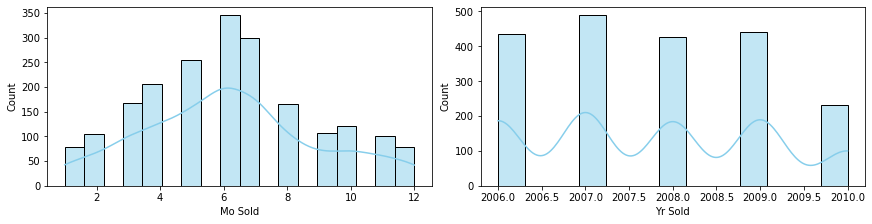

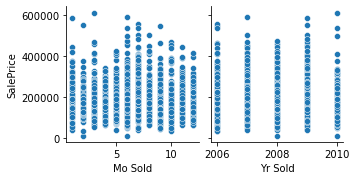

In [224]:
plot_features_numeric(df,features_numeric[30:35],"SalePrice")

In [225]:
print("No outliers found")

No outliers found


In [19]:
# checking linear relationship
print('"total_bsmt_sf" is kind of linear related to "sale_price"')
#features_numeric_final += ["total_bsmt_sf"]

"total_bsmt_sf" is kind of linear related to "sale_price"


In [20]:
# checking outlier and clean 
print(df.shape)
#df.loc[df['total_bsmt_sf']>4_000]

(2051, 81)


In [21]:
if is_delete_outliers :
    df = df.loc[df['total_bsmt_sf']<4_000]
df.shape

(2051, 81)

Index(['1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath'],
      dtype='object')


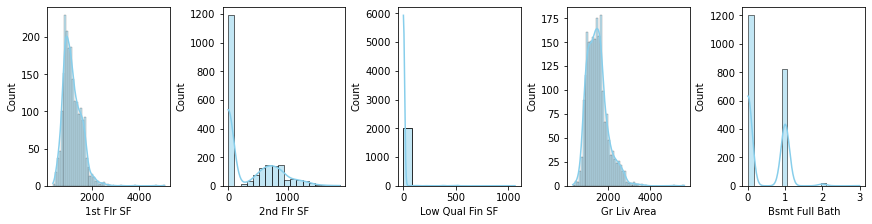

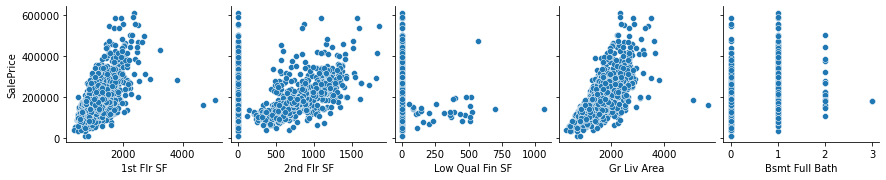

In [22]:
print(features_numeric[10:15])
plot_features_numeric(df,features_numeric[10:15],"SalePrice")

In [23]:
#df['total_flr_sf'] = df['1st_flr_sf'] + df['2nd_flr_sf']

#sns.histplot(data=df, x='total_flr_sf', kde=True, color="skyblue")
#sns.pairplot(df, x_vars='total_flr_sf', y_vars='saleprice')

In [24]:
# checking linear relationship
print("'gr_liv_area' and 'bsmt_full_bath' is kind of linear related to 'sale_price'")
#features_numeric_final += ["gr_liv_area",'bsmt_full_bath']

'gr_liv_area' and 'bsmt_full_bath' is kind of linear related to 'sale_price'


Index(['Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr'],
      dtype='object')


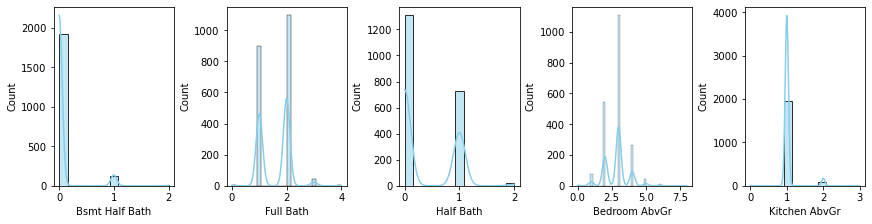

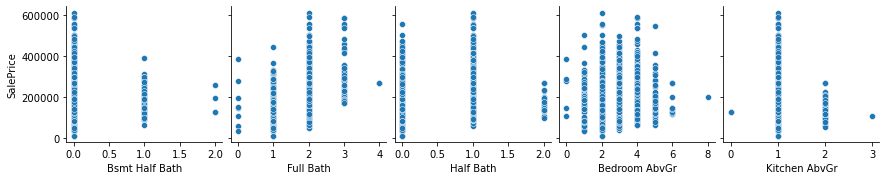

In [25]:
print(features_numeric[15:20])
plot_features_numeric(df,features_numeric[15:20],"SalePrice")

In [26]:
# checking linear relationship

print("'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr' are kind of linear related to 'sale_price'")
#features_numeric_final += ['bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr','kitchen_abvgr']

'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr' are kind of linear related to 'sale_price'


Index(['TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars',
       'Garage Area'],
      dtype='object')


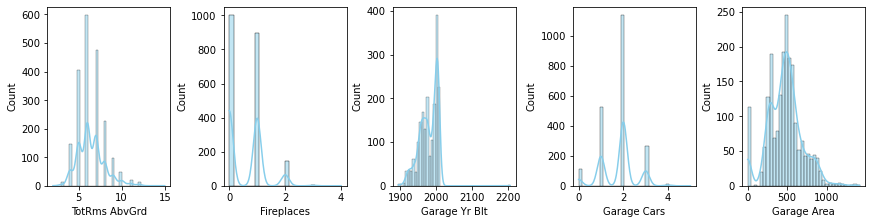

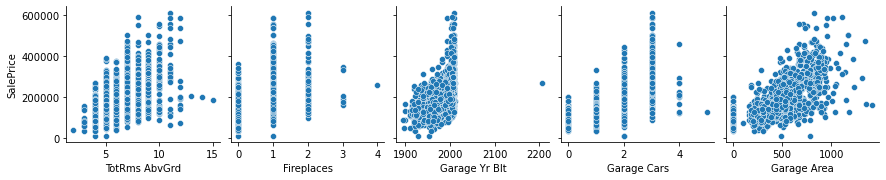

In [27]:
print(features_numeric[20:25])
plot_features_numeric(df,features_numeric[20:25],"SalePrice")


In [28]:
# checking linear relationship
print("'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars','garage_area' are kind of linear related to 'sale_price'")
#features_numeric_final += ['totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars','garage_area']

'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars','garage_area' are kind of linear related to 'sale_price'


In [29]:
# checking outlier and clean 
print(df.shape)
#df.loc[df['garage_yr_blt']>2_200]

(2051, 81)


In [30]:
if is_delete_outliers :
    df=df.loc[df['garage_yr_blt']<2_200]
df.shape

(2051, 81)

In [31]:
#x_column = 'garage_yr_blt'
#sns.histplot(data=df, x=x_column, kde=True, color="skyblue")
#sns.pairplot(df, x_vars=x_column, y_vars='SalePrice')

Index(['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch'],
      dtype='object')


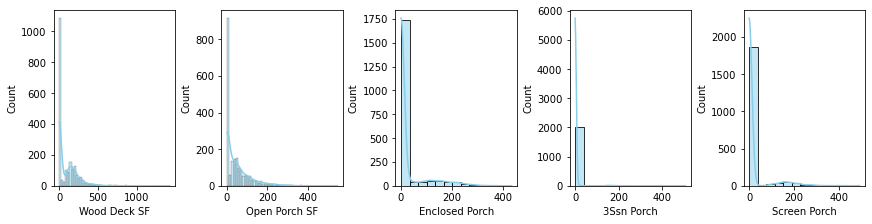

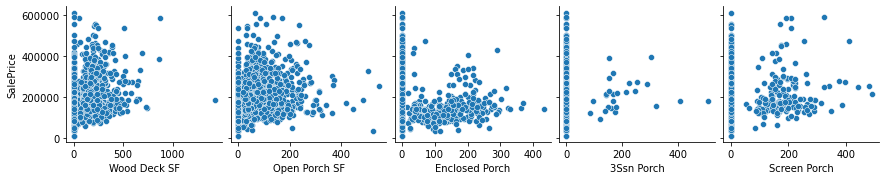

In [32]:
print(features_numeric[25:30])
plot_features_numeric(df,features_numeric[25:30],"SalePrice")

In [33]:
print("cannot find any possible linear relation between these features and 'saleprice'")

cannot find any possible linear relation between these features and 'saleprice'


Index(['Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold'], dtype='object')


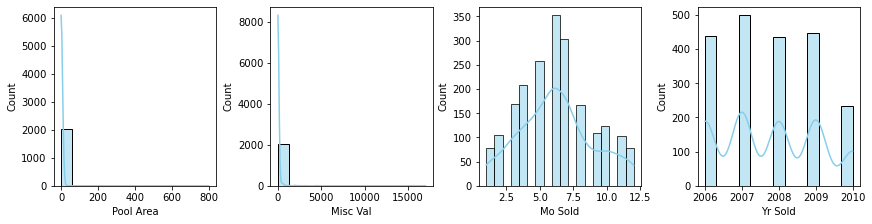

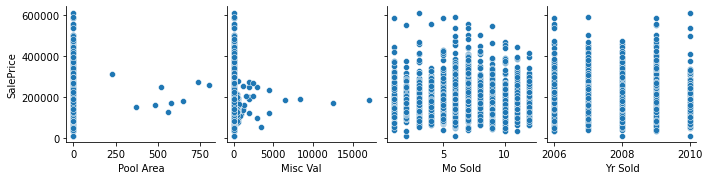

In [34]:
print(features_numeric[30:35])
plot_features_numeric(df,features_numeric[30:35],"SalePrice")

In [35]:
# checking linear relationship
print("'mo_sold', 'yr_sold' are kind of linear related to 'sale_price'")
#features_numeric_final += ['mo_sold', 'yr_sold']

'mo_sold', 'yr_sold' are kind of linear related to 'sale_price'


In [36]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row
'''

'\n#plot the histogram of each numeric feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_numeric)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_numeric)):\n            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])\n    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])\n    i +=columns_in_a_row\n'

In [37]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
            df[features_numeric[i+j]].value_counts(dropna=False).plot(title=features_numeric[i+j], kind='hist',ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row
'''

'\n#plot the histogram of each numeric feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_numeric)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_numeric)):\n            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])\n            df[features_numeric[i+j]].value_counts(dropna=False).plot(title=features_numeric[i+j], kind=\'hist\',ax=axs[j])\n    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])\n    i +=columns_in_a_row\n'

In [38]:
'''
#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_catagorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])
      
    sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
    sns.boxplot(x="ms_subclass", y="saleprice", data=df)
    i +=columns_in_a_row
    
'''

'\n#plot the histogram of each catagorical feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_catagorical)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])\n      \n    sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])\n    sns.boxplot(x="ms_subclass", y="saleprice", data=df)\n    i +=columns_in_a_row\n    \n'

# polynomial

In [593]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 75 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2051 non-null   object  
 1   PID              2051 non-null   object  
 2   MS SubClass      2051 non-null   category
 3   MS Zoning        2051 non-null   category
 4   Lot Area         2051 non-null   int64   
 5   Street           2051 non-null   category
 6   Lot Shape        2051 non-null   object  
 7   Land Contour     2051 non-null   category
 8   Utilities        2051 non-null   object  
 9   Lot Config       2051 non-null   category
 10  Land Slope       2051 non-null   object  
 11  Neighborhood     2051 non-null   category
 12  Condition 1      2051 non-null   category
 13  Condition 2      2051 non-null   category
 14  Bldg Type        2051 non-null   category
 15  House Style      2051 non-null   category
 16  Overall Qual     2051 non-null   int64   


In [595]:
features_poly = features_numeric + ["SalePrice"]
print(features_poly)

['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']


In [596]:
poly = PolynomialFeatures(include_bias=False,interaction_only=False)

df_poly=pd.DataFrame(poly.fit_transform(df[features_poly]),columns=poly.get_feature_names(features_poly))
df_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Columns: 665 entries, Lot Area to SalePrice^2
dtypes: float64(665)
memory usage: 10.4 MB


In [597]:

df_poly.head()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Lot Area^2,Lot Area Overall Qual,Lot Area Overall Cond,Lot Area Year Built,Lot Area Year Remod/Add,Lot Area Mas Vnr Area,Lot Area BsmtFin SF 1,Lot Area BsmtFin SF 2,Lot Area Bsmt Unf SF,Lot Area Total Bsmt SF,Lot Area 1st Flr SF,Lot Area 2nd Flr SF,Lot Area Low Qual Fin SF,Lot Area Gr Liv Area,Lot Area Bsmt Full Bath,Lot Area Bsmt Half Bath,Lot Area Full Bath,Lot Area Half Bath,Lot Area Bedroom AbvGr,Lot Area Kitchen AbvGr,Lot Area TotRms AbvGrd,Lot Area Fireplaces,Lot Area Garage Yr Blt,Lot Area Garage Cars,Lot Area Garage Area,Lot Area Wood Deck SF,Lot Area Open Porch SF,Lot Area Enclosed Porch,Lot Area 3Ssn Porch,Lot Area Screen Porch,Lot Area Pool Area,Lot Area Misc Val,Lot Area Mo Sold,Lot Area Yr Sold,Lot Area SalePrice,Overall Qual^2,Overall Qual Overall Cond,Overall Qual Year Built,Overall Qual Year Remod/Add,Overall Qual Mas Vnr Area,Overall Qual BsmtFin SF 1,Overall Qual BsmtFin SF 2,Overall Qual Bsmt Unf SF,Overall Qual Total Bsmt SF,Overall Qual 1st Flr SF,Overall Qual 2nd Flr SF,Overall Qual Low Qual Fin SF,Overall Qual Gr Liv Area,Overall Qual Bsmt Full Bath,Overall Qual Bsmt Half Bath,Overall Qual Full Bath,Overall Qual Half Bath,Overall Qual Bedroom AbvGr,Overall Qual Kitchen AbvGr,Overall Qual TotRms AbvGrd,Overall Qual Fireplaces,Overall Qual Garage Yr Blt,Overall Qual Garage Cars,Overall Qual Garage Area,Overall Qual Wood Deck SF,Overall Qual Open Porch SF,Overall Qual Enclosed Porch,Overall Qual 3Ssn Porch,Overall Qual Screen Porch,Overall Qual Pool Area,Overall Qual Misc Val,Overall Qual Mo Sold,Overall Qual Yr Sold,Overall Qual SalePrice,Overall Cond^2,Overall Cond Year Built,Overall Cond Year Remod/Add,Overall Cond Mas Vnr Area,Overall Cond BsmtFin SF 1,Overall Cond BsmtFin SF 2,Overall Cond Bsmt Unf SF,Overall Cond Total Bsmt SF,Overall Cond 1st Flr SF,Overall Cond 2nd Flr SF,Overall Cond Low Qual Fin SF,Overall Cond Gr Liv Area,Overall Cond Bsmt Full Bath,Overall Cond Bsmt Half Bath,Overall Cond Full Bath,Overall Cond Half Bath,Overall Cond Bedroom AbvGr,Overall Cond Kitchen AbvGr,Overall Cond TotRms AbvGrd,Overall Cond Fireplaces,Overall Cond Garage Yr Blt,Overall Cond Garage Cars,Overall Cond Garage Area,Overall Cond Wood Deck SF,Overall Cond Open Porch SF,Overall Cond Enclosed Porch,Overall Cond 3Ssn Porch,Overall Cond Screen Porch,Overall Cond Pool Area,Overall Cond Misc Val,Overall Cond Mo Sold,Overall Cond Yr Sold,Overall Cond SalePrice,Year Built^2,Year Built Year Remod/Add,Year Built Mas Vnr Area,Year Built BsmtFin SF 1,Year Built BsmtFin SF 2,Year Built Bsmt Unf SF,Year Built Total Bsmt SF,Year Built 1st Flr SF,Year Built 2nd Flr SF,Year Built Low Qual Fin SF,Year Built Gr Liv Area,Year Built Bsmt Full Bath,Year Built Bsmt Half Bath,Year Built Full Bath,Year Built Half Bath,Year Built Bedroom AbvGr,Year Built Kitchen AbvGr,Year Built TotRms AbvGrd,Year Built Fireplaces,Year Built Garage Yr Blt,Year Built Garage Cars,Year Built Garage Area,Year Built Wood Deck SF,Year Built Open Porch SF,Year Built Enclosed Porch,Year Built 3Ssn Porch,Year Built Screen Porch,Year Built Pool Area,Year Built Misc Val,Year Built Mo Sold,Year Built Yr Sold,Year Built SalePrice,Year Remod/Add^2,Year Remod/Add Mas Vnr Area,Year Remod/Add BsmtFin SF 1,Year Remod/Add BsmtFin SF 2,Year Remod/Add Bsmt Unf SF,Year Remod/Add Total Bsmt SF,Year Remod/Add 1st Flr SF,Year Remod/Add 2nd Flr SF,Year Remod/Add Low Qual Fin SF,Year Remod/Add Gr Liv Area,Year Remod/Add Bsmt Full Bath,Year Remod/Add Bsmt Half Bath,Year Remod/Add Full Bath,Year Remod/Add Half Bath,Year Remod/Add Bedroom AbvGr,Year Remod/Add Kitc

In [615]:
sr_corr = df_poly.corr()['SalePrice'].sort_values(ascending=False)

In [616]:
df_corr = pd.DataFrame({"feature":sr_corr.index, "corr":sr_corr})

In [618]:
df_corr.reset_index(drop=True,inplace=True)

In [623]:
df_corr_filtered= df_corr[~df_corr['feature'].str.contains("SalePrice")]

In [624]:
df_corr_filtered.head(100)

,feature,corr
16,Overall Qual Gr Liv Area,0.837152
17,Overall Qual^2,0.825539
19,Overall Qual Garage Cars,0.820249
20,Overall Qual Garage Area,0.813508
21,Overall Qual Year Built,0.806902
22,Overall Qual Garage Yr Blt,0.805173
23,Overall Qual Year Remod/Add,0.804740
24,Overall Qual,0.800207
25,Overall Qual Yr Sold,0.800185
26,Overall Qual TotRms AbvGrd,0.795420


## ordinal encode all ordinal features

In [526]:
df["Bsmt Qual"].value_counts()

TA    942
Gd    864
Ex    184
Fa     60
Po      1
Name: Bsmt Qual, dtype: int64

In [527]:
print(features_ordinal)

['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope', 'Utilities', 'Lot Shape']


In [528]:
ordinal_cols_mapping = {
    "Lot Shape": {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    "Utilities": {'AllPub':3, 'NoSewr':2, 'NoSeWa':1,  'ELO':0},
    "Land Slope": {'Gtl':2, 'Mod':1 ,'Sev':0},
    "Exter Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Exter Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Bsmt Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Exposure": {'Gd':4, 'Av':3, 'Mn':2 ,'No':1, 'NA':0},
    "BsmtFin Type 1": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "BsmtFin Type 2": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "Heating QC": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Electrical": {'SBrkr':4, 'FuseA':3, 'FuseF':2 ,'FuseP':1, 'Mix':0},
    "Kitchen Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Functional": {'Typ':4, 'Min1':3, 'Min2':2 ,'Mod':1, 'Maj1':0, 'Maj2':-1, 'Sev':-2,'Sal':-3},
    "Garage Finish": {'Fin':4, 'RFn':3, 'Unf':2 ,'NA':1},
    "Garage Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Garage Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Paved Drive": {'Y':2, 'P':1 ,'N':0}
}

df = df.replace(ordinal_cols_mapping)


In [529]:
print(features_categorical)

['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Neighborhood', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning']


In [530]:
#features_final = features_ordinal + features_categorical + features_numeric
features_categorical_selected = ['Condition 2', 'Condition 1', 'Neighborhood','Garage Type','Roof Matl', 'Roof Style']
features_final = features_ordinal + features_numeric + features_categorical
print(features_final)


X = df[features_final]
X = pd.get_dummies(X, columns=X[features_categorical].columns)



df['SalePrice_per_sf'] = df['SalePrice'] / df['Gr Liv Area']
#y = df['SalePrice_per_sf']
y = df['SalePrice']

y.head(10)

['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope', 'Utilities', 'Lot Shape', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 

0    130500
1    220000
2    109000
3    174000
4    138500
5    190000
6    140000
7    142000
8    112500
9    135000
Name: SalePrice, dtype: int64

In [532]:
df1 = pd.get_dummies(df, columns=df[features_categorical].columns)


In [533]:
df1.corr()['SalePrice'].sort_values(ascending=False)

SalePrice               1.000000
Overall Qual            0.800207
Exter Qual              0.712146
Gr Liv Area             0.697038
Kitchen Qual            0.692336
Bsmt Qual               0.682238
Garage Area             0.650246
Garage Cars             0.648197
SalePrice_per_sf        0.631411
Total Bsmt SF           0.628668
1st Flr SF              0.618486
Year Built              0.571849
Year Remod/Add          0.550370
Garage Finish           0.548420
Full Bath               0.537969
Foundation_PConc        0.529047
Garage Yr Blt           0.516738
Mas Vnr Area            0.508602
TotRms AbvGrd           0.504014
Fireplaces              0.471093
Heating QC              0.458354
Neighborhood_NridgHt    0.448647
BsmtFin SF 1            0.423346
Bsmt Exposure           0.413408
Sale Type_New           0.358102
MS SubClass_60          0.355421
Exterior 1st_VinylSd    0.342146
Exterior 2nd_VinylSd    0.337563
Open Porch SF           0.333476
Wood Deck SF            0.326490
Mas Vnr Ty

In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 76 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Id                2051 non-null   object  
 1   PID               2051 non-null   object  
 2   MS SubClass       2051 non-null   category
 3   MS Zoning         2051 non-null   category
 4   Lot Area          2051 non-null   int64   
 5   Street            2051 non-null   category
 6   Lot Shape         2051 non-null   int64   
 7   Land Contour      2051 non-null   category
 8   Utilities         2051 non-null   int64   
 9   Lot Config        2051 non-null   category
 10  Land Slope        2051 non-null   int64   
 11  Neighborhood      2051 non-null   category
 12  Condition 1       2051 non-null   category
 13  Condition 2       2051 non-null   category
 14  Bldg Type         2051 non-null   category
 15  House Style       2051 non-null   category
 16  Overall Qual      2051 n

In [363]:
X.head()

,Paved Drive,Garage Cond,Garage Qual,Garage Finish,Functional,Kitchen Qual,Electrical,Heating QC,BsmtFin Type 2,BsmtFin Type 1,Bsmt Exposure,Bsmt Cond,Bsmt Qual,Exter Cond,Exter Qual,Land Slope,Utilities,Lot Shape,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed
0,2,2,2,3,4,3,4,4,-1,4,1,2,2,2,3,2,3,2,13517,6,8,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,1976.0,2.0,475.0,0,44,0,0,0,0,0,3,2010,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,2,2,2,3,4,3,4,4,-1,4,1,2,3,2,3,2,3,2,11492,7,5,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,1997.0,2.0,559.0,0,74,0,0,0,0,0,4,2009,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,2,2,2,4,3,4,2,-1,4,1,2,2,3,2,2,3,3,7922,5,7,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1953.0,1.0,246.0,0,52,0,0,0,0,0,1,2010,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,2,2,2,4,4,2,4,3,-1,-1,1,2,3,2,2,2,3,3,9802,5,5,2006,2007,0.0,0.0,0.0,384.0,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,2007.0,2.0,400.0,100,0,0,0,0,0,0,4,2010,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,2,2,2,4,2,4,2,-1,-1,1,3,1,2,2,2,3,2,14235,6,8,1900,1993,0.0,0.0,0.0,676.0,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,1957.0,2.0,484.0,0,59,0,0,0,0,0,3,2010,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0


# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# Fit and transform our X data.
X_overfit = poly.fit_transform(X)

In [364]:
#X = pd.get_dummies(X, columns=X[features_categorical].columns)


In [365]:
X.head()


,Paved Drive,Garage Cond,Garage Qual,Garage Finish,Functional,Kitchen Qual,Electrical,Heating QC,BsmtFin Type 2,BsmtFin Type 1,Bsmt Exposure,Bsmt Cond,Bsmt Qual,Exter Cond,Exter Qual,Land Slope,Utilities,Lot Shape,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed
0,2,2,2,3,4,3,4,4,-1,4,1,2,2,2,3,2,3,2,13517,6,8,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,1976.0,2.0,475.0,0,44,0,0,0,0,0,3,2010,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,2,2,2,3,4,3,4,4,-1,4,1,2,3,2,3,2,3,2,11492,7,5,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,1997.0,2.0,559.0,0,74,0,0,0,0,0,4,2009,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,2,2,2,4,3,4,2,-1,4,1,2,2,3,2,2,3,3,7922,5,7,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1953.0,1.0,246.0,0,52,0,0,0,0,0,1,2010,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,2,2,2,4,4,2,4,3,-1,-1,1,2,3,2,2,2,3,3,9802,5,5,2006,2007,0.0,0.0,0.0,384.0,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,2007.0,2.0,400.0,100,0,0,0,0,0,0,4,2010,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,2,2,2,4,2,4,2,-1,-1,1,3,1,2,2,2,3,2,14235,6,8,1900,1993,0.0,0.0,0.0,676.0,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,1957.0,2.0,484.0,0,59,0,0,0,0,0,3,2010,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0


In [370]:
transformer_numeric = Pipeline(
    #steps=[('poly', PolynomialFeatures()), ("scaler", StandardScaler())]
    steps=[('poly', PolynomialFeatures())]
   
)


transformer_categorical = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", transformer_numeric, features_numeric),
     #   ("cat", transformer_categorical, features_categorical),
    ]
)

#clf = Pipeline(
#    steps=[("preprocessor", preprocessor), ("classifier", Lasso())]
#)
#pipeline = Pipeline(steps=[("preprocessor", preprocessor)])


In [367]:

#clf.fit(X_train, y_train)



In [371]:
%%time

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = False
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
best_alpha= None
best_gs = None

for i in range(5):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier__alpha'] = alphas
        param1['classifier'] = [model1]

        # create pipeline
        pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model1)])
        #pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(80, 99)] + [n*temp_best_alpha/100 for n in range(101, 121)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
            print("lkdijf")
            best_mse_test = mse_test
            best_gs = copy.deepcopy(gs)
            best_perc_diff = perc_diff
            best_alpha = temp_best_alpha


C:\Users\olive\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263747215252.00266, tolerance: 975149475.5300276
  model = cd_fast.enet_coordinate_descent(


best performing model: {'classifier': Lasso(alpha=10000), 'classifier__alpha': 10000}
Mse score:  2450717606.452595
mse of train data:  322919868.2152744
mse of test data:  2434680285.8518043
diff%:  -653.9580327800473%
lkdijf


C:\Users\olive\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266194781874.46735, tolerance: 975149475.5300276
  model = cd_fast.enet_coordinate_descent(


best performing model: {'classifier': Lasso(alpha=12000.0), 'classifier__alpha': 12000.0}
Mse score:  2438000496.382978
mse of train data:  325034845.6103376
mse of test data:  2178386698.970963
diff%:  -570.200973338866%


C:\Users\olive\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268391013954.0454, tolerance: 975149475.5300276
  model = cd_fast.enet_coordinate_descent(


best performing model: {'classifier': Lasso(alpha=14040.0), 'classifier__alpha': 14040.0}
Mse score:  2386296980.056389
mse of train data:  327297863.49401593
mse of test data:  1960722066.9491668
diff%:  -499.0635093116076%


KeyboardInterrupt: 

In [324]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

best performing model: {'classifier': Lasso(alpha=29.608402499999997), 'classifier__alpha': 29.608402499999997}
mse of train data:  763898374.0762392
mse of test data:  766554506.6726424
diff%:  -0.347707586053591%


,feature,coef,abs_coef
0,Kitchen AbvGr,-16499.096724,16499.096724
1,Neighborhood,-16417.244156,16417.244156
2,Utilities,14705.310519,14705.310519
3,Exter Qual,10936.200053,10936.200053
4,Kitchen Qual,9810.615205,9810.615205
5,Garage Qual,9326.593695,9326.593695
6,Overall Qual,8538.670129,8538.670129
7,Condition 1,-6846.302577,6846.302577
8,Bsmt Qual,6226.761950,6226.761950
9,Bsmt Full Bath,5756.959329,5756.959329


,feature,coef,abs_coef
0,Garage Cond,1.783487e+04,1.783487e+04
1,Exter Cond,1.545015e+04,1.545015e+04
2,Bedroom AbvGr,1.406941e+04,1.406941e+04
3,BsmtFin SF 2,-1.245023e+04,1.245023e+04
4,Low Qual Fin SF,-1.008686e+04,1.008686e+04
5,Garage Finish,9.461855e+03,9.461855e+03
6,Electrical,8.337625e+03,8.337625e+03
7,Condition 2,-7.765608e+03,7.765608e+03
8,Total Bsmt SF,-7.283549e+03,7.283549e+03
9,Kitchen Qual,5.852996e+03,5.852996e+03


In [149]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Paved Drive      2051 non-null   object  
 1   Garage Cond      2051 non-null   object  
 2   Garage Qual      2051 non-null   object  
 3   Garage Finish    2051 non-null   object  
 4   Functional       2051 non-null   object  
 5   Kitchen Qual     2051 non-null   object  
 6   Electrical       2051 non-null   object  
 7   Heating QC       2051 non-null   object  
 8   BsmtFin Type 2   2051 non-null   object  
 9   BsmtFin Type 1   2051 non-null   object  
 10  Bsmt Exposure    2051 non-null   object  
 11  Bsmt Cond        2051 non-null   object  
 12  Bsmt Qual        2051 non-null   object  
 13  Exter Cond       2051 non-null   object  
 14  Exter Qual       2051 non-null   object  
 15  Land Slope       2051 non-null   object  
 16  Utilities        2051 non-null   object  


# cleaning and selecting catagorical features:
- check if there is linear relation between the feature and 'saleprice'
- check if any outlier and clean if neccessary
- check the histogram of the feature

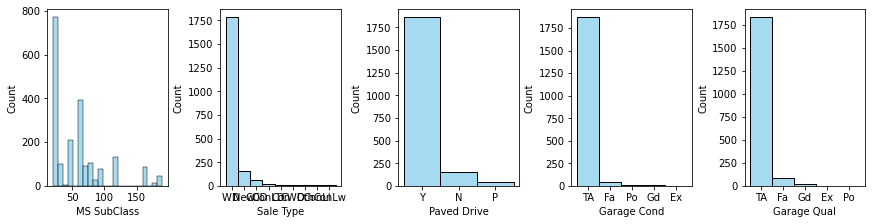

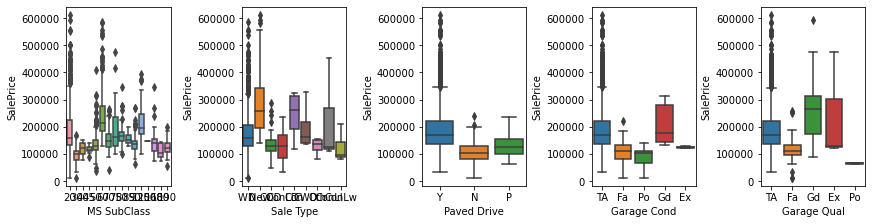

In [39]:
plot_features_catagorical(df,features_catagorical[:5], "SalePrice")

In [40]:
'''
#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_catagorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])
      
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])
            
    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
   
    i +=columns_in_a_row
'''

'\n#plot the histogram of each catagorical feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_catagorical)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])\n      \n    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])\n            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])\n            \n    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])\n   \n    i +=columns_in_a_row\n'

In [41]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_catagorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
            df[features_catagorical[i+j]].value_counts(dropna=False,sort=False).plot(title=features_catagorical[i+j], kind='bar',ax=axs[j])
       
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])
     
    i +=columns_in_a_row
'''

'\n#plot the histogram of each numeric feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_catagorical)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])\n            df[features_catagorical[i+j]].value_counts(dropna=False,sort=False).plot(title=features_catagorical[i+j], kind=\'bar\',ax=axs[j])\n       \n    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])\n            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])\n     \n    i +=columns_in_a_row\n'

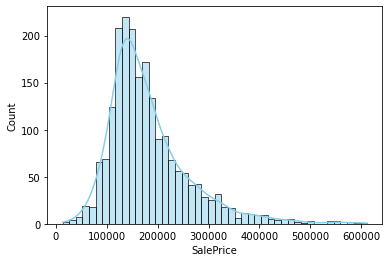

In [42]:
sns.histplot(data=df, x='SalePrice', kde=True, color="skyblue")
plt.show();


In [43]:
from scipy import stats

_, p = stats.normaltest(df['SalePrice'])
print(p)

4.635137528865828e-137


In [44]:
y_sqrt = (df['SalePrice'])**(0.5)
_, p = stats.normaltest(y_sqrt)
print(p)

1.3775989984223007e-49


In [45]:
y_log = np.log(df['SalePrice'])
_, p = stats.normaltest(y_log)
print(p)

3.415079112898754e-22


In [46]:

y_bc, lambda_bc = stats.boxcox(df['SalePrice'])
_, p = stats.normaltest(y_bc)
print(p)

2.3920594213839245e-15


In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lot Frontage,1721.0,69.055200,23.260653,21.0,58.0,68.0,80.00,313.0
Lot Area,2051.0,10065.208191,6742.488909,1300.0,7500.0,9430.0,11513.50,159000.0
Overall Qual,2051.0,6.112140,1.426271,1.0,5.0,6.0,7.00,10.0
Overall Cond,2051.0,5.562165,1.104497,1.0,5.0,5.0,6.00,9.0
Year Built,2051.0,1971.708922,30.177889,1872.0,1953.5,1974.0,2001.00,2010.0
Year Remod/Add,2051.0,1984.190151,21.036250,1950.0,1964.5,1993.0,2004.00,2010.0
Mas Vnr Area,2029.0,99.695909,174.963129,0.0,0.0,0.0,161.00,1600.0
BsmtFin SF 1,2050.0,442.300488,461.204124,0.0,0.0,368.0,733.75,5644.0
BsmtFin SF 2,2050.0,47.959024,165.000901,0.0,0.0,0.0,0.00,1474.0
Bsmt Unf SF,2050.0,567.728293,444.954786,0.0,220.0,474.5,811.00,2336.0


In [48]:
print("garage_yr_blt have wrong max year: 2207")

garage_yr_blt have wrong max year: 2207


In [49]:
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.800207
Gr Liv Area        0.697038
Garage Area        0.650270
Garage Cars        0.648220
Total Bsmt SF      0.628925
1st Flr SF         0.618486
Year Built         0.571849
Year Remod/Add     0.550370
Full Bath          0.537969
Garage Yr Blt      0.533922
Mas Vnr Area       0.512230
TotRms AbvGrd      0.504014
Fireplaces         0.471093
BsmtFin SF 1       0.423519
Lot Frontage       0.341842
Open Porch SF      0.333476
Wood Deck SF       0.326490
Lot Area           0.296566
Bsmt Full Bath     0.283662
Half Bath          0.283001
2nd Flr SF         0.248452
Bsmt Unf SF        0.190210
Bedroom AbvGr      0.137067
Screen Porch       0.134581
3Ssn Porch         0.048732
Mo Sold            0.032735
Pool Area          0.023106
BsmtFin SF 2       0.016255
Misc Val          -0.007375
Yr Sold           -0.015203
Low Qual Fin SF   -0.041594
Bsmt Half Bath    -0.045328
Overall Cond      -0.097019
Kitchen AbvGr     -0.125444
Enclosed Porch    -0

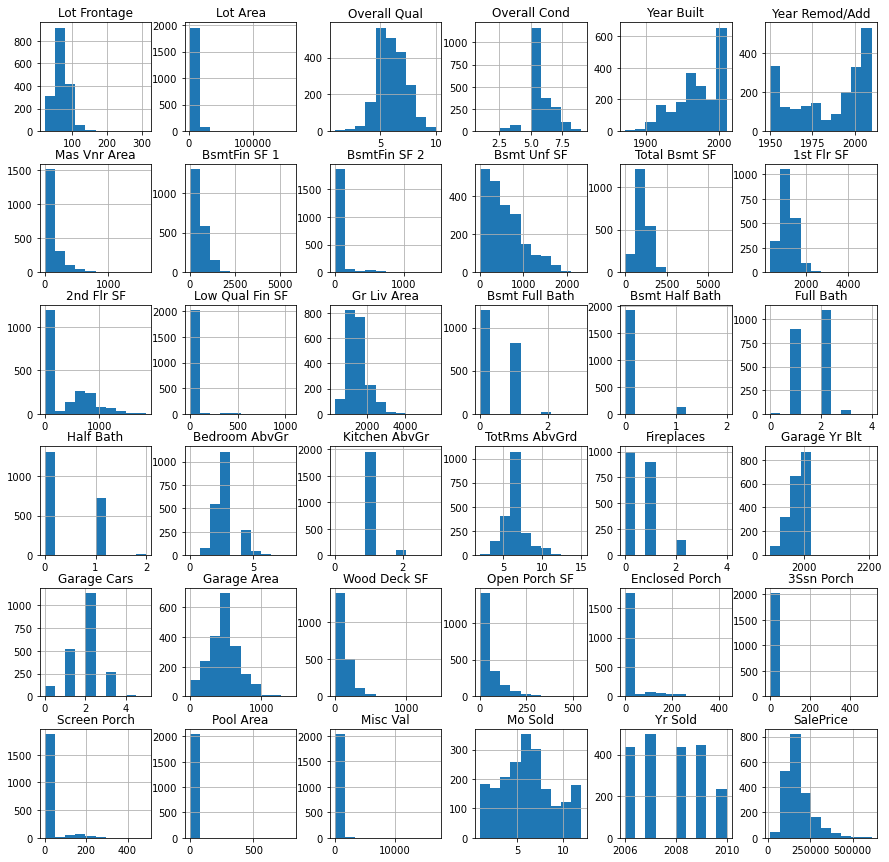

In [50]:
df.hist(figsize=(15, 15));

### EDA: Boxplots

C:\Users\olive\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


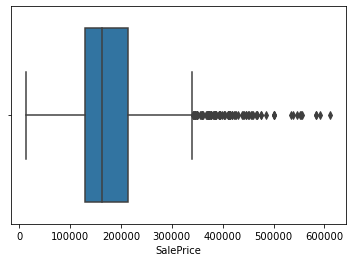

In [51]:
sns.boxplot(df['SalePrice']);

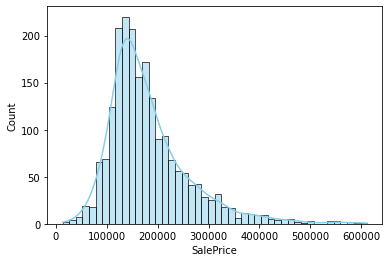

In [52]:
sns.histplot(data=df, x='SalePrice', kde=True, color="skyblue")
plt.show();

### get dummy the catagorical features

In [53]:
df = pd.get_dummies(df, columns=features_catagorical)

In [54]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 292 columns):
 #    Column                Dtype  
---   ------                -----  
 0    Id                    object 
 1    PID                   object 
 2    Misc Feature          object 
 3    Fence                 object 
 4    Pool QC               object 
 5    Fireplace Qu          object 
 6    Alley                 object 
 7    Lot Frontage          float64
 8    Lot Area              int64  
 9    Overall Qual          int64  
 10   Overall Cond          int64  
 11   Year Built            int64  
 12   Year Remod/Add        int64  
 13   Mas Vnr Area          float64
 14   BsmtFin SF 1          float64
 15   BsmtFin SF 2          float64
 16   Bsmt Unf SF           float64
 17   Total Bsmt SF         float64
 18   1st Flr SF            int64  
 19   2nd Flr SF            int64  
 20   Low Qual Fin SF       int64  
 21   Gr Liv Area           int64  
 22   Bsmt Full Bath        

In [55]:
features_dummies = df.columns[-249:]
print(features_dummies)

Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Lot Shape_Reg', 'Street_Grvl', 'Street_Pave', 'MS Zoning_A (agr)',
       'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)',
       'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM'],
      dtype='object', length=249)


### Model Prep: Create our features matrix ( X ) and target vector ( y )

In [56]:
features_final = features_dummies.union(features_numeric,sort=False)
print(features_final)


Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold',
       'Yr Sold'],
      dtype='object', length=283)


In [57]:
X = df[features_final]
X.head()

,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Central Air_N,Central Air_Y,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,Bsmt Cond_Ex,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_Po,Bsmt Cond_TA,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Utilities_AllPub,Utilities_

In [58]:
y = df['SalePrice']
y.head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

### fill missing data with mean

In [59]:
X.isnull().sum().sort_values(ascending=False)

Garage Yr Blt           114
Mas Vnr Area             22
Bsmt Full Bath            2
Bsmt Half Bath            2
Garage Cars               1
Garage Area               1
Bsmt Unf SF               1
BsmtFin SF 2              1
BsmtFin SF 1              1
Total Bsmt SF             1
Condition 1_Artery        0
Condition 1_PosN          0
Condition 2_RRNn          0
Condition 1_Feedr         0
Condition 1_Norm          0
Condition 1_PosA          0
Condition 2_RRAn          0
Condition 2_RRAe          0
Condition 2_PosN          0
Condition 2_PosA          0
Condition 2_Norm          0
Condition 2_Feedr         0
MS SubClass_20            0
Condition 1_RRNe          0
Condition 1_RRAe          0
Condition 1_RRAn          0
Neighborhood_Landmrk      0
Neighborhood_IDOTRR       0
Neighborhood_GrnHill      0
Neighborhood_Greens       0
Neighborhood_Gilbert      0
Neighborhood_Edwards      0
Neighborhood_Crawfor      0
Neighborhood_CollgCr      0
Neighborhood_ClearCr      0
Neighborhood_BrkSide

In [60]:
X.fillna(X.mean(),inplace=True)

C:\Users\olive\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [61]:
X.isnull().sum().sort_values(ascending=False)

MS SubClass_20          0
Condition 1_Norm        0
Condition 1_RRNn        0
Condition 1_RRNe        0
Condition 1_RRAn        0
Condition 1_RRAe        0
Condition 1_PosN        0
Condition 1_PosA        0
Condition 1_Feedr       0
Neighborhood_Blueste    0
Condition 1_Artery      0
Condition 2_RRNn        0
Condition 2_RRAn        0
Condition 2_RRAe        0
Condition 2_PosN        0
Condition 2_PosA        0
Neighborhood_Blmngtn    0
Neighborhood_BrDale     0
Neighborhood_NridgHt    0
Neighborhood_IDOTRR     0
Neighborhood_NWAmes     0
Neighborhood_NPkVill    0
Neighborhood_NAmes      0
Neighborhood_Mitchel    0
Neighborhood_MeadowV    0
Neighborhood_Landmrk    0
Neighborhood_GrnHill    0
Neighborhood_BrkSide    0
Neighborhood_Greens     0
Neighborhood_Gilbert    0
Neighborhood_Edwards    0
Neighborhood_Crawfor    0
Neighborhood_CollgCr    0
Neighborhood_ClearCr    0
Condition 2_Norm        0
Condition 2_Feedr       0
Condition 2_Artery      0
Roof Matl_ClyTile       0
Roof Style_F

### Model Prep: Train/test split
We always want to have a holdout set to test our model. Use the train_test_split function to split our X and y variables into a
training set and a holdout set.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [64]:
%%time


# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = True
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = LinearRegression()
model2 = Ridge()
model3 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
best_alpha= None
best_gs = None

for i in range(10):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier'] = [model1]
        param2 = {}
        param2['classifier__alpha'] = alphas
        param2['classifier'] = [model2]
        param3 = {}
        param3['classifier__alpha'] = alphas
        param3['classifier'] = [model3]

        # create pipeline
        #pipeline = Pipeline(steps=[('scaler', scaler), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1, param2, param3]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(50, 99)] + [n*temp_best_alpha/100 for n in range(101, 151)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
             best_mse_test = mse_test
             best_gs = copy.deepcopy(gs)
             best_perc_diff = perc_diff
             best_alpha = temp_best_alpha


best performing model: {'classifier': Ridge(alpha=10), 'classifier__alpha': 10}
Mse score:  937187908.0642482
mse of train data:  628007372.677255
mse of test data:  603358715.555092
diff%:  3.9248993235674114%
best performing model: {'classifier': Ridge(alpha=9.3), 'classifier__alpha': 9.3}
Mse score:  936944597.083717
mse of train data:  622338103.1290655
mse of test data:  601727444.982696
diff%:  3.3118104198892433%
best performing model: {'classifier': Ridge(alpha=9.393), 'classifier__alpha': 9.393}
Mse score:  936949971.3212099
mse of train data:  623103641.7080833
mse of test data:  601940452.0294892
diff%:  3.3964156621810946%
best performing model: {'classifier': Ridge(alpha=9.205140000000002), 'classifier__alpha': 9.205140000000002}
Mse score:  936948229.223739
mse of train data:  621553125.1439406
mse of test data:  601511365.9910703
diff%:  3.224464384798803%
best performing model: {'classifier': Ridge(alpha=9.2971914), 'classifier__alpha': 9.2971914}
Mse score:  936944571.

In [65]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
       

best performing model: {'classifier': Lasso(alpha=59.66053560974846), 'classifier__alpha': 59.66053560974846}
mse of train data:  494463643.18597955
mse of test data:  495085972.52618814
diff%:  -0.12585947395418862%


In [689]:
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_

In [690]:
"""
coefs_list = sorted(list(zip(features_final,coefs)),reverse=True, key=lambda x: np.abs(x[1]))
for i in coefs_list: 
    print(i)
"""

('roof_matl_ClyTile', -414140.8680330434)
('neighborhood_GrnHill', 67264.85295290376)
('neighborhood_StoneBr', 46523.50190183723)
('roof_matl_WdShngl', 35353.543763068934)
('neighborhood_NoRidge', 31905.300487457374)
('exter_qual_Ex', 31866.29367384054)
('neighborhood_NridgHt', 27146.013303712167)
('kitchen_qual_Ex', 19581.681317092374)
('exterior_1st_BrkFace', 14158.211886174468)
('bldg_type_1Fam', 13587.018506763057)
('neighborhood_Crawfor', 13259.660235852527)
('roof_style_Mansard', -12889.512602039658)
('condition_1_PosN', 12563.43597372949)
('bsmt_exposure_Gd', 12341.441610161846)
('neighborhood_Somerst', 11453.087977094681)
('functional_Maj1', -9686.19503824734)
('neighborhood_Edwards', -9447.278140696133)
('sale_type_New', 9322.233333402157)
('bsmt_qual_Ex', 8884.057070557226)
('mas_vnr_type_BrkCmn', -8742.071668090928)
('land_contour_HLS', 8376.469256799917)
('overall_qual', 8356.179575032469)
('functional_Typ', 7752.615500814012)
('sale_type_COD', -6760.0908177584115)
('garage

In [699]:
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

,feature,coef,abs_coef
0,roof_matl_ClyTile,-4.141409e+05,4.141409e+05
1,neighborhood_GrnHill,6.726485e+04,6.726485e+04
2,neighborhood_StoneBr,4.652350e+04,4.652350e+04
3,roof_matl_WdShngl,3.535354e+04,3.535354e+04
4,neighborhood_NoRidge,3.190530e+04,3.190530e+04
5,exter_qual_Ex,3.186629e+04,3.186629e+04
6,neighborhood_NridgHt,2.714601e+04,2.714601e+04
7,kitchen_qual_Ex,1.958168e+04,1.958168e+04
8,exterior_1st_BrkFace,1.415821e+04,1.415821e+04
9,bldg_type_1Fam,1.358702e+04,1.358702e+04


# Multicollinearity

In [159]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                  feature         VIF
0                lot_area    3.229927
1            overall_qual    6.150540
2            overall_cond    2.737041
3              year_built   17.901058
4          year_remod/add    3.990474
5            mas_vnr_area    3.171225
6            bsmtfin_sf_1         inf
7            bsmtfin_sf_2         inf
8             bsmt_unf_sf         inf
9           total_bsmt_sf         inf
10             1st_flr_sf         inf
11             2nd_flr_sf         inf
12        low_qual_fin_sf         inf
13            gr_liv_area         inf
14         bsmt_full_bath    2.713863
15         bsmt_half_bath    1.449874
16              full_bath    4.077185
17              half_bath    2.890186
18          bedroom_abvgr    3.333105
19          kitchen_abvgr    4.918167
20          totrms_abvgrd    6.084003
21             fireplaces    2.201143
22          garage_yr_blt    5.492629
23            garage_cars    9.730312
24            garage_area    9.009234
25          

In [163]:
df_coefs = pd.DataFrame(coefs_list)
df_coefs.columns = ["feature", 'coefs']
df_lr_params = pd.merge(left = df_coefs,
                        right = vif_data, 
                        on ="feature" )

df_lr_params.sort_values(by=['coefs'],ascending=False,inplace=True)
df_lr_params.reset_index(inplace=True,drop=True)
df_lr_params.head(100)

,feature,coefs,VIF
0,neighborhood_GrnHill,66286.413858,inf
1,neighborhood_StoneBr,46357.763285,inf
2,roof_matl_WdShngl,34597.904324,inf
3,exter_qual_Ex,31791.814638,inf
4,neighborhood_NoRidge,31734.034901,inf
5,neighborhood_NridgHt,27079.708110,inf
6,kitchen_qual_Ex,19714.467298,inf
7,exterior_1st_BrkFace,14186.934758,inf
8,bldg_type_1Fam,13588.164758,inf
9,neighborhood_Crawfor,13277.761323,inf


# LINE Assumptions

In [ ]:
# L - Linearity

In [ ]:
# I - Independence

In [ ]:
# N - Normality of errors
plt.hist(resids, bins=50);

In [ ]:
# E - Equal variance of errors
plt.scatter(y_pred, resids, s=1)
plt.axhline(0, color="orange");

# testing the kaggle output

In [799]:
# read the files
df_test = pd.read_csv("../datasets/test.csv")
df_test.head().T

,0,1,2,3,4
Id,2658,2718,2414,1989,625
PID,902301120,905108090,528218130,902207150,535105100
MS SubClass,190,90,60,30,20
MS Zoning,RM,RL,RL,RM,RL
Lot Frontage,69.0,NaN,58.0,60.0,NaN
Lot Area,9142,9662,17104,8520,9500
Street,Pave,Pave,Pave,Pave,Pave
Alley,Grvl,NaN,NaN,NaN,NaN
Lot Shape,Reg,IR1,IR1,Reg,IR1
Land Contour,Lvl,Lvl,Lvl,Lvl,Lvl


In [800]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

### after comparing the data directory and dataframe Dtypes, and found the following columns need to convert to string type
- id
- pid
- ms_subclass

In [801]:
#rename column
#df.columns=df.columns.str.lower()
#df.columns=df.columns.str.replace(" ","_")
#change column type, according to data directory
str_type_columns=["Id", "PID","MS SubClass"]
for column in str_type_columns:
    df_test[column]=df_test[column].astype("object")

In [802]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    object 
 1   PID              878 non-null    object 
 2   MS SubClass      878 non-null    object 
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [803]:
#rearrange the columns such that all feature of 'object' type will be moved before all numeric 

columns_copy = df_test.columns.tolist()
for column in columns_copy:
    if df_test[column].dtype == object:
        column_to_reorder = df_test.pop(column)
        df_test.insert(3, column, column_to_reorder)
   # else:
    #    df2.insert(-1, df.columns[i], column_to_reorder)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    object 
 1   PID              878 non-null    object 
 2   MS SubClass      878 non-null    object 
 3   Sale Type        878 non-null    object 
 4   Misc Feature     41 non-null     object 
 5   Fence            172 non-null    object 
 6   Pool QC          4 non-null      object 
 7   Paved Drive      878 non-null    object 
 8   Garage Cond      833 non-null    object 
 9   Garage Qual      833 non-null    object 
 10  Garage Finish    833 non-null    object 
 11  Garage Type      834 non-null    object 
 12  Fireplace Qu     456 non-null    object 
 13  Functional       878 non-null    object 
 14  Kitchen Qual     878 non-null    object 
 15  Electrical       877 non-null    object 
 16  Central Air      878 non-null    object 
 17  Heating QC      

In [754]:
print("from above, we can see: column #2 to #44 are of catagorical features  ")
print("from above, we can see: column #44 and above are of numeric features  ")

from above, we can see: column #2 to #44 are of catagorical features  
from above, we can see: column #44 and above are of numeric features  


In [806]:
features_catagorical_test = df_test.columns[2:45]
print(features_catagorical_test)

features_numeric_test = df_test.columns[45:-1]
print(features_numeric_test)

Index(['MS SubClass', 'Sale Type', 'Misc Feature', 'Fence', 'Pool QC',
       'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish',
       'Garage Type', 'Fireplace Qu', 'Functional', 'Kitchen Qual',
       'Electrical', 'Central Air', 'Heating QC', 'Heating', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Foundation', 'Exter Cond', 'Exter Qual', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Neighborhood', 'Land Slope', 'Lot Config', 'Utilities', 'Land Contour',
       'Lot Shape', 'Alley', 'Street', 'MS Zoning'],
      dtype='object')
Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt H

## checking null values

In [807]:
(df_test.isnull().sum()/len(df_test)).sort_values(ascending=False)

Pool QC            0.995444
Misc Feature       0.953303
Alley              0.933941
Fence              0.804100
Fireplace Qu       0.480638
Lot Frontage       0.182232
Garage Yr Blt      0.051253
Garage Cond        0.051253
Garage Qual        0.051253
Garage Finish      0.051253
Garage Type        0.050114
Bsmt Cond          0.028474
Bsmt Exposure      0.028474
BsmtFin Type 1     0.028474
BsmtFin Type 2     0.028474
Bsmt Qual          0.028474
Mas Vnr Type       0.001139
Electrical         0.001139
Mas Vnr Area       0.001139
Gr Liv Area        0.000000
Bsmt Full Bath     0.000000
Low Qual Fin SF    0.000000
Bsmt Half Bath     0.000000
Id                 0.000000
Bsmt Unf SF        0.000000
2nd Flr SF         0.000000
1st Flr SF         0.000000
Total Bsmt SF      0.000000
Half Bath          0.000000
BsmtFin SF 2       0.000000
BsmtFin SF 1       0.000000
Full Bath          0.000000
Garage Area        0.000000
Bedroom AbvGr      0.000000
Kitchen AbvGr      0.000000
TotRms AbvGrd      0

we will not consider the following features with too many null value:

|feature|null value %|
------------------------------
Pool QC            0.995612

Misc Feature       0.968308

Alley              0.931741

Fence              0.804973

Fireplace Qu       0.487567

Lot Frontage       0.160897

In [808]:
features_numeric_test=features_numeric_test.drop('Lot Frontage')
print(features_numeric_test)

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars',
       'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold'],
      dtype='object')


In [809]:
features_catagorical_test=features_catagorical_test.drop(['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu'])
print(features_catagorical_test)

Index(['MS SubClass', 'Sale Type', 'Paved Drive', 'Garage Cond', 'Garage Qual',
       'Garage Finish', 'Garage Type', 'Functional', 'Kitchen Qual',
       'Electrical', 'Central Air', 'Heating QC', 'Heating', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Foundation', 'Exter Cond', 'Exter Qual', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Neighborhood', 'Land Slope', 'Lot Config', 'Utilities', 'Land Contour',
       'Lot Shape', 'Street', 'MS Zoning'],
      dtype='object')


In [811]:
df_test = pd.get_dummies(df_test, columns=features_catagorical_test)

In [812]:
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 275 columns):
 #    Column                Dtype  
---   ------                -----  
 0    Id                    object 
 1    PID                   object 
 2    Misc Feature          object 
 3    Fence                 object 
 4    Pool QC               object 
 5    Fireplace Qu          object 
 6    Alley                 object 
 7    Lot Frontage          float64
 8    Lot Area              int64  
 9    Overall Qual          int64  
 10   Overall Cond          int64  
 11   Year Built            int64  
 12   Year Remod/Add        int64  
 13   Mas Vnr Area          float64
 14   BsmtFin SF 1          int64  
 15   BsmtFin SF 2          int64  
 16   Bsmt Unf SF           int64  
 17   Total Bsmt SF         int64  
 18   1st Flr SF            int64  
 19   2nd Flr SF            int64  
 20   Low Qual Fin SF       int64  
 21   Gr Liv Area           int64  
 22   Bsmt Full Bath        in

In [814]:
features_dummies_test = df_test.columns[-233:]
print(features_dummies_test)

Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Lot Shape_IR3', 'Lot Shape_Reg', 'Street_Grvl', 'Street_Pave',
       'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)',
       'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM'],
      dtype='object', length=233)


### Model Prep: Create our features matrix ( X ) and target vector ( y )

In [817]:
features_final_test = features_dummies_test.union(features_numeric_test,sort=False)
print(features_final_test)


Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo Sold'],
      dtype='object', length=266)


In [818]:
X_kaggle = df_test[features_final_test]
X_kaggle.head()

,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_160,MS SubClass_180,MS SubClass_190,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Central Air_N,Central Air_Y,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_TA,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_TA,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Other,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Roof Matl_CompShg,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Utilities_AllPub,Utilities_NoSewr,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Street_Grvl,Street_Pave,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,

### fill missing data with mean

In [819]:
X_kaggle.isnull().sum().sort_values(ascending=False)

Garage Yr Blt           45
Mas Vnr Area             1
MS SubClass_20           0
Condition 1_Norm         0
Condition 1_RRNe         0
Condition 1_RRAn         0
Condition 1_RRAe         0
Condition 1_PosN         0
Condition 1_PosA         0
Condition 1_Feedr        0
Neighborhood_Blmngtn     0
Condition 1_Artery       0
Condition 2_PosA         0
Condition 2_Norm         0
Condition 2_Feedr        0
Bldg Type_TwnhsE         0
Condition 1_RRNn         0
Neighborhood_Blueste     0
Bldg Type_Duplex         0
Neighborhood_BrDale      0
Neighborhood_BrkSide     0
Neighborhood_ClearCr     0
Neighborhood_CollgCr     0
Neighborhood_Crawfor     0
Neighborhood_Edwards     0
Neighborhood_Gilbert     0
Neighborhood_Greens      0
Neighborhood_IDOTRR      0
Neighborhood_MeadowV     0
Neighborhood_Mitchel     0
Neighborhood_NAmes       0
Neighborhood_NPkVill     0
Neighborhood_NWAmes      0
Bldg Type_Twnhs          0
Bldg Type_1Fam           0
Bldg Type_2fmCon         0
Neighborhood_NridgHt     0
E

In [821]:
X_kaggle.fillna(X.mean(),inplace=True)
X_kaggle.isnull().sum().sort_values(ascending=False)

MS SubClass_20          0
Neighborhood_Blueste    0
Bldg Type_TwnhsE        0
Condition 2_Feedr       0
Condition 2_Norm        0
Condition 2_PosA        0
Condition 1_Artery      0
Condition 1_Feedr       0
Condition 1_Norm        0
Condition 1_PosA        0
Condition 1_PosN        0
Condition 1_RRAe        0
Condition 1_RRAn        0
Condition 1_RRNe        0
Condition 1_RRNn        0
Neighborhood_Blmngtn    0
Neighborhood_BrDale     0
Neighborhood_OldTown    0
Neighborhood_BrkSide    0
Neighborhood_ClearCr    0
Neighborhood_CollgCr    0
Neighborhood_Crawfor    0
Neighborhood_Edwards    0
Neighborhood_Gilbert    0
Neighborhood_Greens     0
Neighborhood_IDOTRR     0
Neighborhood_MeadowV    0
Neighborhood_Mitchel    0
Neighborhood_NAmes      0
Neighborhood_NPkVill    0
Neighborhood_NWAmes     0
Neighborhood_NoRidge    0
Bldg Type_Twnhs         0
Bldg Type_Duplex        0
Bldg Type_2fmCon        0
Bldg Type_1Fam          0
Exterior 1st_CemntBd    0
Exterior 1st_HdBoard    0
Exterior 1st

#  producing kaggle prediction

In [823]:
y_kaggle_pred = best_gs.predict(X_kaggle)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 283 is different from 266)